# SET UP

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import imutils
import glob
from skimage import exposure
from skimage import feature
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## I. Lý thuyết tính toán

In [2]:
# Đọc và chuyển ảnh qua Grayscale
image = cv2.imread(r'./Dataset/train/9/01.jpeg', cv2.IMREAD_GRAYSCALE)

In [3]:
def _subImage(image1, string1 ,image2, string2):
    fix, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(image1, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(string1)
    axs[1].imshow(image2, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(string2)
    plt.show()

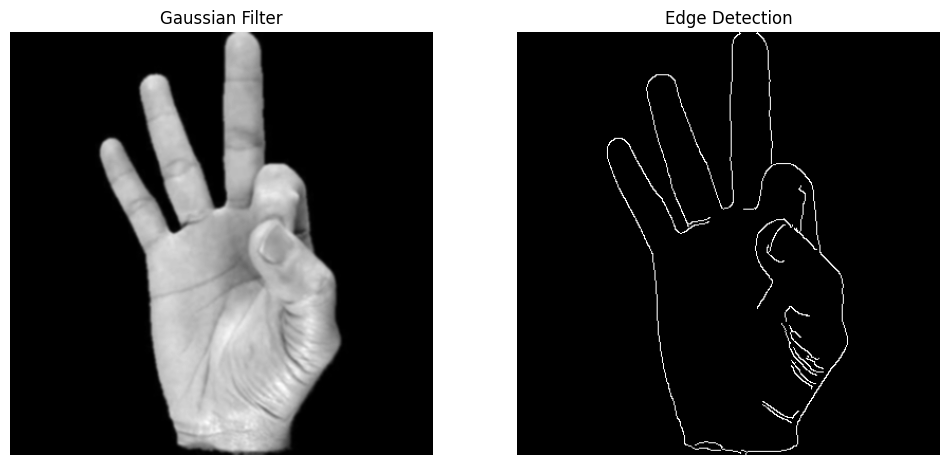

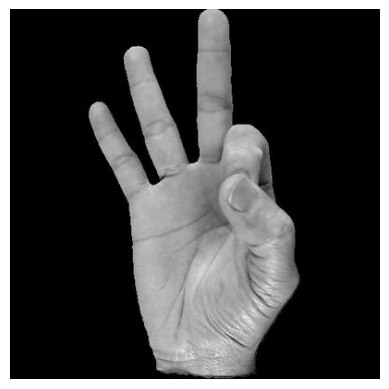

In [10]:
gau_image = cv2.GaussianBlur(image, (5,5), 0) # Giam nhieu
edges = cv2.Canny(gau_image, 50, 150) # Phat hien bien su dung Cannt function

# Hiển thị ảnh sau khi tách biên
_subImage(gau_image, "Gaussian Filter", edges, "Edge Detection")
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

In [49]:
orb = cv2.ORB_create()
key, des = orb.detectAndCompute(edges, None)
image_extract = cv2.drawKeypoints(edges, key, None, flags=0)

# _subImage(edges, "Edge Detection", image_extract, "Feature Extract")
print(des.flatten())
des = np.array(des)
des.size
# des = np.array(des)
# des.shape
# des = des.flatten()
# print(des)
# print(des.shape)


[ 66  34   0 ... 183 218   4]


16064

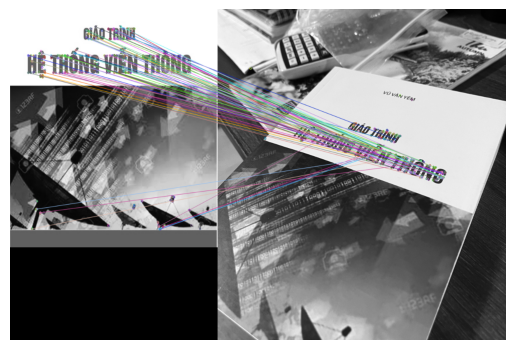

In [6]:
import numpy as np
import cv2


# Read the query image as query_img
# and train image This query image
# is what you need to find in train image
# Save it in the same directory
# with the name image.jpg
query_img = cv2.imread('./img.png')
# query_img = cv2.resize(query_img, (400,400))
train_img = cv2.imread('./img_1.png')
train_img = cv2.resize(train_img, (1000,1000))

# Convert it to grayscale
query_img_bw = cv2.cvtColor(query_img,cv2.COLOR_BGR2GRAY)
train_img_bw = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)

# Initialize the ORB detector algorithm
orb = cv2.ORB_create()

# Now detect the keypoints and compute
# the descriptors for the query image
# and train image
queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_bw,None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(train_img_bw,None)

# Initialize the Matcher for matching
# the keypoints and then match the
# keypoints
matcher = cv2.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)

# draw the matches to the final image
# containing both the images the drawMatches()
# function takes both images and keypoints
# and outputs the matched query image with
# its train image
final_img = cv2.drawMatches(query_img_bw, queryKeypoints, train_img_bw, trainKeypoints, matches[:70],None)
final_img = cv2.resize(final_img, (1200,800))
plt.imshow(final_img, cmap='plasma')
plt.axis('off')
plt.show()

# II. Xử lý biên và trích xuất đặc trưng

In [70]:
def _preprocessing(fileType):
    data = []
    labels = []
    orb = cv2.ORB_create()

    for path in glob.glob(fileType):
        _, type, fn = path.split('\\')
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img, (5,5), 0)
        edges = cv2.Canny(img, 50, 150)

        queryKeypoints, descriptors = orb.detectAndCompute(edges, None)
        descriptors = descriptors.flatten()
        data.append(descriptors)
        labels.append(type)
    # data = np.array(data, dtype=object)
    # labels = np.array(labels, dtype=object)
    return data, labels

data, labels= _preprocessing('./Dataset/train/**/*.jpeg')


In [66]:
max_length = max(len(arr) for arr in data)
data_array = np.zeros((len(data), max_length))

for i, arr in enumerate(data):
    data_array[i, :len(arr)] = arr/255.0

X_train = data_array
la = LabelEncoder()
la = la.fit(labels)
y_train = la.transform(labels)

# print(X_train.ndim)
X_train

array([[0.41176471, 0.00784314, 0.04705882, ..., 0.        , 0.        ,
        0.        ],
       [0.25098039, 0.63529412, 0.54901961, ..., 0.        , 0.        ,
        0.        ],
       [0.25098039, 0.13333333, 0.01568627, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.95686275, 0.26666667, 0.0745098 , ..., 0.        , 0.        ,
        0.        ],
       [0.47843137, 0.1254902 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.35294118, 0.1254902 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(456, 16352) (114, 16352) (456,) (114,)


In [69]:
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='distance')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score1 = accuracy_score(y_test, y_pred)
print(accuracy_score1)

0.18421052631578946


In [23]:
def _save(path, obj):
    with open(path, 'wb') as fn:
        pickle.dump(obj, fn)

## III. Chuyển đổi dữ liệu

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

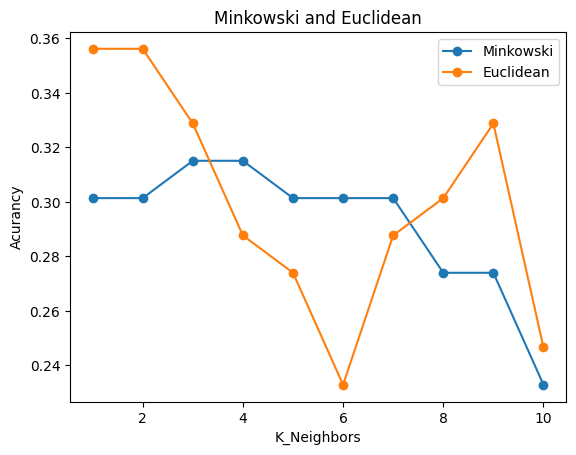

In [63]:
n_neighbors_list = list(range(1, 11))
result_L1 = []
result_L2 = []
for n_neighbors in n_neighbors_list:
    # Mô hình KNN với distance measure là L1
    model_L1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=n_neighbors, p=1,
           weights='distance')
    model_L1.fit(X_train, y_train)
    # Dự đoán nhãn lớp trên tập kiểm tra
    y_pred = model_L1.predict(X_test)
    accuracy_L1 = accuracy_score(y_test, y_pred)
    result_L1.append(accuracy_L1)


    # Mô hình KNN với distance measure là L2
    model_L2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric_params=None, n_jobs=None, n_neighbors=n_neighbors, p=2,
           weights='distance')
    model_L2.fit(X_train, y_train)
    # Dự đoán nhãn lớp trên tập kiểm tra
    y_pred = model_L2.predict(X_test)
    accuracy_L2 = accuracy_score(y_test, y_pred)
    result_L2.append(accuracy_L2)

plt.plot(n_neighbors_list, result_L1, marker='o', label='Minkowski')
plt.plot(n_neighbors_list, result_L2, marker='o', label='Euclidean')
plt.xlabel('K_Neighbors')
plt.ylabel('Acurancy')
plt.title('Minkowski and Euclidean')
plt.legend()
plt.show()

del result_L1 # Phải xóa đi không run lại nó lại điền tiếp kết quả zô mảng --> kết quả bị sai nha
del result_L2